In [9]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from network import Network

v_0 = 10e-6     # Loading velocity [m/s]
k = 14.8*1e9    # Spring stiffness [Pa/m]
beta_1 = 1.2    # b₁/a₀ [non-dim]
L_1 = 3*1e-6    # Critical distance for θ₁ [m]
rho = 0.1
L_2 = rho*L_1

a = 0.01        # Friction direct effect [non-dim]
mu_0 = 0.64       # Static friction coefficient [non-dim]
lam = a/mu_0

G = 31e9         # Rigidity modulus of quartz [Pa]
rho_v = 2.65e3   # Density of quartz [kg/m^3]
c_s = np.sqrt(G/rho_v)
eta_0 = G/(2*c_s)
eta = 1*eta_0

p_0 = 1.01325e5  # Reference surrounding pressure (atmospheric pressure) [Pa]

beta_a = 1e-9    #[0.5-4]*1e-9 (David et al., 1994; see Segall and Rice, 1995)
beta_m = 1e-11       # Compressibility of Quartz (Pimienta et al., 2017, JGR, fig. 12)
phi_0 = 0.075       # Reference porosity
beta = phi_0*(beta_a+beta_m)
epsilon = -0.017*1e-3  # Dilatancy/Compressibility coefficient
#
c_0 = 10          # Diffusivity [1/s]
gamma = c_0*L_1/v_0

# sigma_n0 = 17.003*1e6

# 简化参数
# tau_0 = mu_0*sigma_n0  # (10)
# kappa = (k*L_1) / (a*sigma_n0) #26(a)
# nu = eta*v_0 / (a*sigma_n0) #26(b)
# rho = rho
# beta_2 = -epsilon/(lam*beta*sigma_n0) #26(d)
# alpha = (c_0*p_0*L_1) / (v_0*lam*sigma_n0)  #26(e)
# gamma = gamma

# 定义一个类，用于实现PINN(Physics-informed Neural Networks)
class PINN:
    # 构造函数
    def __init__(self,data_path,seed):
        # 选择使用GPU还是CPU
        device = torch.device("mps")
        torch.manual_seed(seed)  # 设置 PyTorch 的随机种子
        np.random.seed(seed)     # 设置 NumPy 的随机种子
        # 定义神经网络
        self.model = Network(
            input_size=1,  # 输入层神经元数
            hidden_size=200,  # 隐藏层神经元数
            output_size=4,  # 输出层神经元数
            depth=4,  # 隐藏层数xc
            act=torch.nn.Tanh  # 输入层和隐藏层的激活函数
        ).to(device)  # 将这个神经网络存储在GPU上（若GPU可用）

        self.sigma_n = torch.nn.Parameter(torch.tensor(np.log(30e6), dtype=torch.float32).to(device))
        self.sigma_n0 = torch.exp(self.sigma_n)

        # self.sigma_n0 = torch.nn.Parameter(torch.tensor(20.003e6).to(device))
        # 定义依赖于sigma_n0的参数（这些是动态的，因为sigma_n0会更新）
        self.tau_0 = mu_0 * self.sigma_n0
        self.kappa = (k * L_1) / (a * self.sigma_n0)
        self.nu = eta * v_0 / (a * self.sigma_n0)
        self.beta_2 = -epsilon / (lam * beta * self.sigma_n0)
        self.alpha = (c_0 * p_0 * L_1) / (v_0 * lam * self.sigma_n0)

        self.k = 0.1  # 设置时间步长
        t = torch.arange(0, 6, self.k)  # 在[0,1]区间上均匀取值，记为t

        # 形成时间网格，记录在张量X_inside中
        self.X_inside = t.reshape(1, -1).T

        # 网格数据
        self.X_inside_data = torch.tensor(np.loadtxt(data_path)[:,1]*a*17.003+mu_0 * 17.003, dtype=torch.float32)

        # 边界处的时空坐标
        ic = t[0].reshape(1, -1).T # t=0边界
        self.X_boundary = ic  # 将所有边界处的时空坐标点整合为一个张量

        # 边界处的u值
        u_ic = torch.tensor([[0.0014851490120946023,-0.3807304456678973,0.0001626260574953936,-0.3814333184281347]])  # t=0边界处采用第一类边界条件u=-sin(pi*x)
        self.U_boundary = torch.cat([u_ic])  # 将所有边界处的u值整合为一个张量

        # 将数据拷贝到GPU
        self.X_inside = self.X_inside.to(device)
        self.X_inside_data = self.X_inside_data.to(device)
        self.X_boundary = self.X_boundary.to(device)
        self.U_boundary = self.U_boundary.to(device)
        self.X_inside.requires_grad = True  # 设置：需要计算对X的梯度

        # 设置准则函数为MSE，方便后续计算MSE
        self.criterion = torch.nn.MSELoss()

        # 定义迭代序号，记录调用了多少次loss
        self.iter = 1

        # 初始化最小损失和最佳模型状态
        self.min_loss = float('inf')
        self.best_model_state = None
        self.best_sigma_n0 = None

        # 初始化损失记录列表
        self.loss_equation0_history = []
        self.loss_boundary_history = []
        self.loss_data_history = []
        self.loss_all_history = []
        self.sigma_history = []

        self.lbfgs = torch.optim.LBFGS(
            list(self.model.parameters()) + [self.sigma_n],
            lr=0.0005,
            max_iter=4000,
            max_eval=4000,
            history_size=50,
            tolerance_grad=1e-12,
            tolerance_change=1e-12,#1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )

        # 设置adam优化器
        self.adam = torch.optim.Adam(list(self.model.parameters()) + [self.sigma_n],lr=0.03)#3e-3

    def compute_residuals(self):
        U_inside = self.model(self.X_inside)

        self.tau_0 = mu_0 * self.sigma_n0
        self.kappa = (k * L_1) / (a * self.sigma_n0)
        self.nu = eta * v_0 / (a * self.sigma_n0)
        self.beta_2 = -epsilon / (lam * beta * self.sigma_n0)
        self.alpha = (c_0 * p_0 * L_1) / (v_0 * lam * self.sigma_n0)

        x, y, z, u = U_inside[:, 0].squeeze(), U_inside[:, 1].squeeze(), U_inside[:, 2].squeeze(), U_inside[:,
                                                                                                   3].squeeze()

        du_dX_all = []
        for i in range(4):
            du_dX_i = torch.autograd.grad(
                inputs=self.X_inside,
                outputs=U_inside[:, i],
                grad_outputs=torch.ones_like(U_inside[:, i]),
                retain_graph=True,
                create_graph=True
            )[0]
            du_dX_all.append(du_dX_i.squeeze())

        x_t, y_t, z_t, u_t = du_dX_all[0], du_dX_all[1], du_dX_all[2], du_dX_all[3]

        residual_z = z_t - (-rho * (self.beta_2 * x + z) * torch.exp(x))
        residual_u = u_t - (-self.alpha - gamma * u + z_t)
        residual_x = x_t - (torch.exp(x) * ((beta_1 - 1) * x * (1 + lam * u) + y - u) + self.kappa * (1 - torch.exp(x)) - u_t * (
                        1 + lam * y) / (1 + lam * u)) / (1 + lam * u + self.nu * torch.exp(x))
        residual_y = y_t - (self.kappa * (1 - torch.exp(x)) - self.nu * torch.exp(x) * x_t)

        return torch.stack([residual_x, residual_y, residual_z, residual_u], dim=1)

    # 损失函数
    def loss_func(self):
        # 将导数清零
        self.adam.zero_grad()
        self.lbfgs.zero_grad()

        # 更新依赖参数（因为sigma_n0可能变化）
        self.tau_0 = mu_0 * self.sigma_n0
        self.kappa = (k * L_1) / (a * self.sigma_n0)
        self.nu = eta * v_0 / (a * self.sigma_n0)
        self.beta_2 = -epsilon / (lam * beta * self.sigma_n0)
        self.alpha = (c_0 * p_0 * L_1) / (v_0 * lam * self.sigma_n0)

        # 第一部分loss: 边界条件不吻合产生的loss
        U_pred_boundary = self.model(self.X_boundary)  # 使用当前模型计算u在边界处的预测值
        loss_boundary = self.criterion(
            U_pred_boundary, self.U_boundary)  # 计算边界处的MSE

        # 第二部分loss:内点非物理产生的loss
        U_inside = self.model(self.X_inside)  # 使用当前模型计算内点处的预测值

        x, y, z, u = U_inside[:,0].squeeze(), U_inside[:,1].squeeze(), U_inside[:,2].squeeze(), U_inside[:,3].squeeze()

        # 使用自动求导方法得到U对X的导数
        du_dX_all = []
        for i in range(4):
            du_dX_i = torch.autograd.grad(
                inputs=self.X_inside,
                outputs=U_inside[:,i],
                grad_outputs=torch.ones_like(U_inside[:,i]),
                retain_graph=True,
                create_graph=True
            )[0]
            du_dX_all.append(du_dX_i.squeeze())

        x_t, y_t, z_t, u_t = du_dX_all[0], du_dX_all[1], du_dX_all[2], du_dX_all[3]

        loss_z = self.criterion(z_t, - rho * (self.beta_2 * x + z) * torch.exp(x))
        loss_u = self.criterion(u_t, - self.alpha - gamma * u + z_t)
        loss_x = self.criterion(x_t,(torch.exp(x)*((beta_1-1)*x*(1+lam*u)+y-u)+self.kappa*(1-torch.exp(x)) - u_t*(1+lam*y)/(1+lam*u))/(1+lam*u+self.nu*torch.exp(x)))
        loss_y = self.criterion(y_t, self.kappa*(1 - torch.exp(x)) - self.nu*torch.exp(x)*x_t)

        # 自适应权重：根据残差调整权重
        residuals = self.compute_residuals()
        weights = torch.clamp(torch.abs(residuals).mean(dim=0), min=1.0, max=10.0)  # 计算每个方程的平均残差，并限制范围
        loss_equation0 = (loss_x * weights[0] + loss_y * weights[1] + loss_z * weights[2] + loss_u * weights[
            3]) / weights.sum()  # 加权求和并归一化

        # 第三部分loss：数据损失
        loss_data = self.criterion(y*a*self.sigma_n0/1e6+mu_0 * self.sigma_n0/1e6, self.X_inside_data)
        # alpha = np.random.uniform(0.8, 1.0)
        scaling_factor = (loss_equation0 / loss_data) * 0.8

        # 最终的loss由三项组成
        loss = loss_equation0 + 0.5*loss_boundary + loss_data*scaling_factor

        self.loss_equation0_history.append(loss_equation0.item())
        self.loss_boundary_history.append(loss_boundary.item()*0.5)
        self.loss_data_history.append(loss_data.item()*scaling_factor.cpu().detach().numpy())
        self.loss_all_history.append(loss.item())

        if loss.item() < self.min_loss:
            self.min_loss = loss.item()
            self.best_model_state = self.model.state_dict()
            self.best_sigma_n = self.sigma_n.item()

        # loss反向传播，用于给优化器提供梯度信息
        loss.backward(retain_graph=True)
        # print("Gradient of sigma_n0:", self.sigma_n0.grad)
        self.sigma_history.append(self.sigma_n.item())

        # 每计算100次loss在控制台上输出消息
        if self.iter % 100 == 0:
            print(self.iter, loss.item(), "Current sigma_n:", np.exp(self.sigma_n.item()))
        self.iter = self.iter + 1
        return loss

    # 训练
    def train(self):
        self.model.train()  # 设置模型为训练模式

        # 首先运行5000步Adam优化器
        # print("采用Adam优化器")
        # for i in range(600):
        #     self.adam.step(self.loss_func)
        # if self.best_model_state is not None:
        #     torch.save(self.best_model_state, 'model.pth')

        # 然后运行lbfgs优化器
        # self.model.load_state_dict(torch.load('model.pth'))
        print("采用L-BFGS优化器")
        self.lbfgs.step(self.loss_func)

        print("Final inverted sigma_n:", self.best_sigma_n)
        print("Final inverted sigma_n0:", np.exp(self.best_sigma_n))

        # 保存最佳模型
    def save_best_model(self, path='model.pth'):
        if self.best_model_state is not None:
            torch.save(self.best_model_state, path)
            print(f"Best model saved with loss {self.min_loss} at {path}")
        else:
            print("No best model state found to save.")

    def plot_loss(self):
        plt.rcParams['font.family'] = 'Arial'  # 设置字体为 Arial（你也可以选择其他字体）
        plt.rcParams['font.size'] = 14

        plt.figure(figsize=(10, 6))
        iterations = range(1, len(self.loss_equation0_history) + 1)
        plt.plot(iterations, self.loss_equation0_history, label='ODE Equation Loss', color='blue')
        plt.plot(iterations, self.loss_boundary_history,  label='Initial Condition Loss', color='red')
        plt.plot(iterations, self.loss_data_history, label='Data Loss', color='orange')
        plt.plot(iterations, self.loss_all_history, label='Total Loss', color='black')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Across Epochs')
        plt.legend()
        plt.grid(True)
        plt.yscale('log')  # 使用对数刻度以更好地显示损失变化
        plt.savefig('../plot/figure/loss_plot_inverse.pdf', dpi=300)
        plt.show()


seeds=[41]#[42,43,46,48,50,52,53,54,56,57]
pinns = []
for seed in seeds:
    pinn = PINN(data_path = 'data1.txt',seed=seed)
    pinn.train()
    pinns.append(pinn)


pinn.save_best_model()

采用L-BFGS优化器
100 0.0023499447852373123 Current sigma_n: 28691118.123661704
200 0.0007899624761193991 Current sigma_n: 23616205.192900553
300 0.0004057054757140577 Current sigma_n: 20261557.23033252
400 0.0003287667641416192 Current sigma_n: 18670663.730929784
500 0.00030165465432219207 Current sigma_n: 18514311.127058983
600 0.00028564600506797433 Current sigma_n: 18410183.775303267
700 0.0002796362969093025 Current sigma_n: 18354121.00276875
800 0.0001916701439768076 Current sigma_n: 16732253.124945812
Final inverted sigma_n: 16.63105583190918
Final inverted sigma_n0: 16702280.616231361
Best model saved with loss 0.0001916170003823936 at model.pth


In [10]:
def plot_setting(ax):
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
        spine.set_edgecolor('black')
    ax.tick_params(axis='both', direction='out', length=6, width=1.5)
    ax.tick_params(axis='x', which='both', left=True,bottom=True, top=False, labelbottom=True)
    ax.tick_params(axis='y', which='both', left=True, right=False)

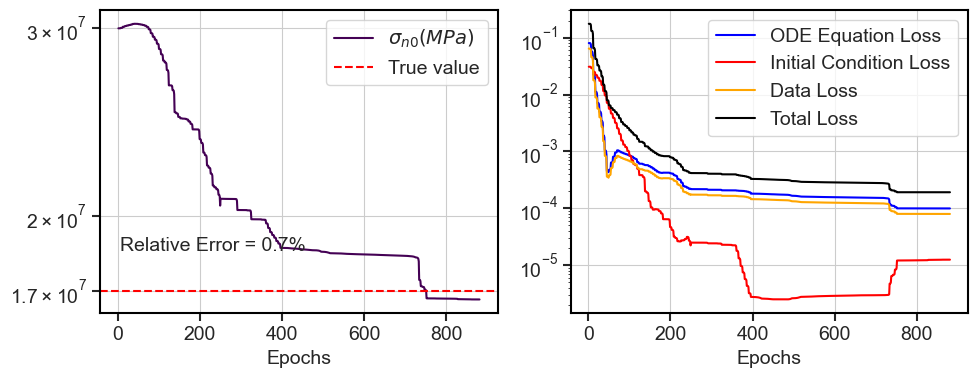

In [11]:
def plot_sigma_loss(pinns):
    plt.rcParams['font.family'] = 'Arial'  # 设置字体为 Arial（你也可以选择其他字体）
    plt.rcParams['font.size'] = 14

    colors = plt.cm.viridis(np.linspace(0, 1, len(pinns)))
    plt.figure(figsize=(10,4))
    ax11 = plt.subplot(1, 2, 1)
    i=0
    for pinn in pinns:
        iterations = range(1, len(pinn.loss_equation0_history) + 1)
        ax11.plot(iterations, np.exp(pinn.sigma_history),c=colors[i],label='$\sigma_{n0} (MPa)$')
        i+=1
    ax11.axhline(y=17.003 * 1e6, color='red', linestyle='--',label='True value')
    ax11.ticklabel_format(axis='y',style='plain',useOffset=False)
    ax11.set_xlabel('Epochs')
    ax11.text(0.05, 0.25, 'Relative Error = 0.7%', transform=ax11.transAxes, fontsize=14, verticalalignment='top')
    ax11.legend()
    ax11.grid(True, which='both')  # 启用主要和次要刻度的网格线
    ax11.set_yscale('log')  # 使用对数刻度以更好地显示损失变化
    ax11.set_yticks([17* 1e6, 2e7, 3e7])
    plot_setting(ax11)

    ax12 = plt.subplot(1, 2, 2)
    iterations = range(1, len(pinn.loss_equation0_history) + 1)
    ax12.plot(iterations, pinn.loss_equation0_history, label='ODE Equation Loss', color='blue')
    ax12.plot(iterations, pinn.loss_boundary_history,  label='Initial Condition Loss', color='red')
    ax12.plot(iterations, pinn.loss_data_history, label='Data Loss', color='orange')
    ax12.plot(iterations, pinn.loss_all_history, label='Total Loss', color='black')
    ax12.set_xlabel('Epochs')
    # ax12.set_xlim(0,400)
    ax12.legend()
    ax12.grid(True)
    ax12.set_yscale('log')
    plot_setting(ax12)

    plt.tight_layout()
    # plt.show()
    plt.savefig('../plot/figure/inverse.pdf',dpi=300)

plot_sigma_loss(pinns)

In [ ]:
(17.003*1e6-17139014.646692675)/(17.003*1e6)